[참고(proj_2)](https://colab.research.google.com/drive/1Z_fQ3JNxnuVIcMf89Q7vGylU6dtn-zAW?usp=sharing)

# [네이버 쇼핑몰](https://wikidocs.net/94600)

## 1. 데이터 로드

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f7712ddbc10>)

In [ ]:
data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])         # column 명이 없으므로 지정해주기

In [ ]:
data.info

<bound method DataFrame.info of         ratings                                            reviews
0             5                                            배공빠르고 굿
1             2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2             5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3             2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4             5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...         ...                                                ...
199995        2                                    장마라그런가!!! 달지않아요
199996        5  다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997        5                    로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998        5                                      넘이쁘고 쎄련되보이네요~
199999        5   아직 사용해보지도않았고 다른 제품을 써본적이없어서 잘 모르겠지만 ㅎㅎ 배송은 빨랐습니다

[200000 rows x 2 columns]>

## 2. 훈련 데이터와 테스트 데이터 분리하기

현재 데이터의 ratings는 1~5(3 제외) 값을 가지고 있으므로 평점이 4, 5점인 리뷰에는 레이블 1을, 평점이 1, 2점인 리뷰에는 레이블 0을 부여하는 label를 만든다.

In [ ]:
data['label'] = np.select([data.ratings > 3], [1], default = 0)                  # np.select를 사용하여 데이터 기존은 ratings 컬럼을 가져와 그 값이 3 이상인 평점에는 1을 부여하고 나머지에는 0을 부여하는 새로운 컬럼을 만든다.

In [ ]:
data.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


각 열에 대해서 중복을 제외한 샘플의 수를 카운트

In [ ]:
print(data['ratings'].nunique())
print(data['reviews'].nunique())
print(data['label'].nunique())

4
199908
2


위의 data['reviews'].nunique()의 개수가 199908이고 data.info로 확인한 전체 열의 개수는 200000임을 비교하였을 때, 중복 데이터가 있다는 것을 확인할 수 있다.

In [ ]:
data.drop_duplicates(subset = ['reviews'], inplace = True)                        # reviews 열에서 중복인 내용이 있다면 중복 내용을 제거
print('총 샘플의 수 : ', len(data))

총 샘플의 수 :  199908


In [ ]:
print(data.isnull().values.any())                                                # NULL 값의 유무 확인 -> NULL 값은 존재하지 않는다.

False


In [ ]:
# 만약, NULL 값이 존재했을 경우
data = data.dropna(how = 'any')
print('NULL 값을 제외한 총 샘플의 수 : ', len(data))

NULL 값을 제외한 총 샘플의 수 :  199908


## 3. 레이블의 분포를 확인(감정의 분포 확인)

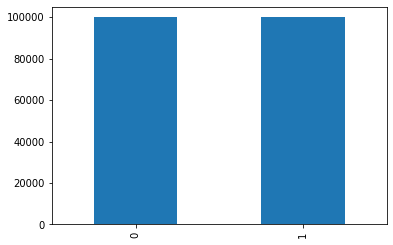

In [ ]:
data['label'].value_counts().plot(kind = 'bar')                            # 감정의 분포를 그래프의 형태로 확인
plt.show()

In [ ]:
display(data.groupby('label').size().reset_index(name = 'count'))          # 감정의 개수를 확인
# groupby를 사용하여 train_data의 ['label'] 컬럼으로 묶어내고 그 숫자를 count이름의 인덱스로 표현

,label,count
0,0,99955
1,1,99953


## 4. 데이터 정제하기

정규식 표현을 사용하여 한글을 제외한 텍스트를 제거(이 과정에서 빈 샘플이 생길 수 있다)

In [ ]:
# 한글과 공백을 제외하고 모두 제거
data['reviews'] = data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

data['reviews'].replace('', np.nan, inplace = True)                         # 한글과 공백을 제외한 텍스트를 제거할 때 생기게 되는 공백을 Nan 값으로 변경

print(data.isnull().sum())                                                  # 공백이 포함되어 있는지 확인

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


만약 바로 위의 과정에서 공백이 생긴다면 데이터 처리를 다시 한번 진행

In [ ]:
data = data.dropna(how = 'any')
print('NALL 값을 제외한 train_data의 샘플 수 : ', len(data))

NALL 값을 제외한 train_data의 샘플 수 :  199908


## 5. 토큰화

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 695 kB/s 
     |████████████████████████████████| 453 kB 58.4 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 5.44 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-22 23:56:37--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [ ]:
from konlpy.tag import Mecab

In [ ]:
tokenizer = Mecab()
print(tokenizer.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [ ]:
# 불용어 지정(없어도 큰 문제는 없을 듯)
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고',
             '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
# 위키독스에 나오는 내용보다는 수업 시간에 사용하던 함수를 정의하여 사용하는 것이 훨씬 편리하다고 생각됨
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):

    text_data = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence)
        curr_data = [word for word in curr_data if not word in stopwords]
        text_data.append(curr_data)
    return text_data

In [ ]:
data_token = tokenize_and_remove_stopwords(data['reviews'], stopwords, tokenizer)

# 6. 단어장 만들기

In [ ]:
def load_data(data_token, num_words=10000):

    # 단어장
    words = np.concatenate(data_token).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    text_token = list(map(wordlist_to_indexlist, data_token))

    x_train, x_test, y_train, y_test = train_test_split(text_token, 
                                                        data['label'],
                                                        test_size = 0.25,
                                                        random_state = 42)

    return x_train, x_test, y_train, y_test, word_to_index

In [ ]:
x_train, x_test, y_train, y_test, word_to_index = load_data(data_token)

In [ ]:
print(x_train[0])

[69, 2070, 307, 2, 265, 71, 8, 239, 175, 141, 808, 2972, 653, 4, 79, 64, 207, 42, 1378, 157, 5, 8]


# 7. encoding, decoding

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index):                                                        # 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):                                                # 숫자 -> 텍스트
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
get_decoded_sentence(x_train[0], index_to_word)

'센치 씩 <UNK> 건데 작 아요 그리고 색상 완전 달라요 칙칙 핑크 네요 ㅠㅠ 많이 아쉽 지만 암막 효과 좋 아요'

# 8. 모델 구성을 위한 데이터 분석 및 가공

In [ ]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.313719310883005
문장길이 최대 : 85
문장길이 표준편차 :  10.98579340736084
pad_sequences maxlen :  37
전체 문장의 0.9441192948756428%가 maxlen 설정값 이내에 포함됩니다. 


# 9. 패딩

In [ ]:
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

# 10. 모델 구성

In [ ]:
vocab_size = 10000
word_vector_dim = 200                                                            # 2의 배수, 단어에 대한 차원 지정

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


# 11. 모델 훈련

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(x_train, y_train, epochs=epochs, batch_size=500,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
300/300 [==============================] - 10s 11ms/step - loss: 0.3321 - accuracy: 0.8777 - val_loss: 0.2588 - val_accuracy: 0.9049
Epoch 2/100
300/300 [==============================] - 2s 8ms/step - loss: 0.2326 - accuracy: 0.9173 - val_loss: 0.2460 - val_accuracy: 0.9103
Epoch 3/100
300/300 [==============================] - 2s 8ms/step - loss: 0.2070 - accuracy: 0.9277 - val_loss: 0.2388 - val_accuracy: 0.9129
Epoch 4/100
300/300 [==============================] - 2s 8ms/step - loss: 0.1864 - accuracy: 0.9357 - val_loss: 0.2362 - val_accuracy: 0.9146
Epoch 5/100
300/300 [==============================] - 2s 8ms/step - loss: 0.1690 - accuracy: 0.9428 - val_loss: 0.2475 - val_accuracy: 0.9124
Epoch 6/100
300/300 [==============================] - 2s 8ms/step - loss: 0.1553 - accuracy: 0.9478 - val_loss: 0.2590 - val_accuracy: 0.9116
Epoch 7/100
300/300 [==============================] - 2s 8ms/step - loss: 0.1429 - accuracy: 0.9525 - val_loss: 0.2706 - val_accuracy: 0.90

In [ ]:
model.evaluate(x_test, y_test, verbose=2)

1562/1562 - 5s - loss: 1.1370 - accuracy: 0.8825 - 5s/epoch - 3ms/step


[1.1369951963424683, 0.8825459480285645]

# 12. loss, accuracy 그래프 시각화

In [ ]:
history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

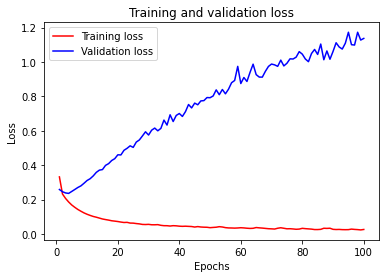

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

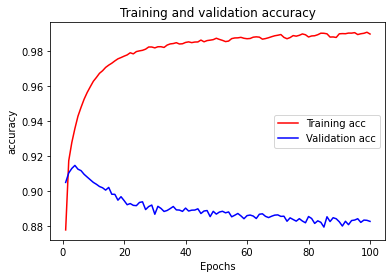

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

[첨부(예시_1)](https://drive.google.com/file/d/1U1KRGipcD5cKg9ibFwRso2vgmYi_NKBs/view?usp=sharing) [첨부(예시_2)](https://drive.google.com/file/d/1YquWTaTqkSDWlXAE0Fn_GJRzeOQiohjq/view?usp=sharing) [첨부(예시_3)](https://drive.google.com/file/d/1j7xcHAg3P-JBXco4y-idZCNoPjUOUFem/view?usp=sharing)